In [1]:
import pandas as pd
import numpy as np
import pickle
import data_processing as dp

In [3]:
class Config:
    def __init__(self):
        self.data_path = 'data/'
        self.holdings_file_name=self.data_path+"SHARADAR_holdings.csv"
        self.all_tickers_file_name=self.data_path+"all_tickers.csv"
        self.all_investors_file_name=self.data_path+"all_investors.csv"
        self.all_dates_file_name=self.data_path+"all_dates.csv"
        self.all_value_file_name=self.data_path+"all_value.csv"
        self.load_full_data=False
        self.create_dimension_files=True
        self.create_dense_matrices=False

config=Config()

In [4]:
import data_processing as dp
import importlib
importlib.reload(dp)
df=None
print ("Loading full data set")
print(config.holdings_file_name)
if(config.load_full_data==True):
    df=dp.load_full_data_set(config.holdings_file_name)

Loading full data set
data/SHARADAR_holdings.csv


df has the relational data. 
the columns are:
- ticker
- investorname
- calendardate
- value
- units
- price

I have created the dimensions:
- ticker
- investorname
- calendardate

I have created the measures:
- value


In [6]:
#df_pivot = df.pivot_table(index=['ticker', 'investorname', 'calendardate'])
df
len(df)
print(df.columns)

Index(['ticker', 'investorname', 'calendardate', 'value', 'units', 'price'], dtype='object')


In [6]:
importlib.reload(dp)
(ticker_to_index, investor_to_index, date_to_index)=dp.get_dimensions(config.create_dimension_files,config.all_tickers_file_name,config.all_investors_file_name,config.all_dates_file_name,df)


In [9]:

importlib.reload(dp)
array_3d=dp.get_dense_values(df,ticker_to_index, investor_to_index, date_to_index)


AttributeError: 'NoneType' object has no attribute 'iterrows'

In [12]:
importlib.reload(dp)
data_3d=dp.get_3d_data(config.create_dense_matrices,ticker_to_index,investor_to_index,date_to_index,df)
arr_vals=data_3d["values"]

Select only the investors that have non zero ownehership in the company for every quarter in the dataset

In [13]:
inv_portfolio_total=np.sum(arr_vals,axis=0)
inv_portfolio_total_nz=np.sum(arr_vals!=0,axis=0)
print(f'arr_vals.shape={arr_vals.shape}')
print(f'bla.shape={inv_portfolio_total.shape}')
print(f'number of inverstor={len(data_3d["investors"])}')
inv_portfolio_all_quarters=np.all(inv_portfolio_total_nz>0,axis=1)
investor_to_index_subset={k: v for k, v in investor_to_index.items() if inv_portfolio_all_quarters[v]==True}

arr_vals.shape=(15662, 9472, 32)
bla.shape=(9472, 32)
number of inverstor=9472


In [33]:
inv_portfolio_all_quarters
np.sum(inv_portfolio_all_quarters)
len(list(investor_to_index_subset.values()))

1859

In [14]:
stock_ownership=np.sum(arr_vals,axis=1)
stock_ownership_nz=np.sum(arr_vals!=0,axis=1)
print(f'stock_ownership.shape={stock_ownership.shape}')
print(f'number of tickers={len(data_3d["tickers"])}')
stock_ownership_all_quarters=np.all(stock_ownership_nz>0,axis=1)
ticker_to_index_subset={k: v for k, v in ticker_to_index.items() if stock_ownership_all_quarters[v]==True}


stock_ownership.shape=(15662, 32)
number of tickers=15662


In [15]:
len(ticker_to_index_subset)
len(ticker_to_index)

15662

In [20]:
ticker_subset_list=list(ticker_to_index_subset.keys())
ticker_subset_indeces=list(ticker_to_index_subset.values())
investor_subset_list=list(investor_to_index_subset.keys())
investor_subset_indeces=list(investor_to_index_subset.values())
arr_vals_subset=arr_vals[ticker_subset_indeces,:,:]
arr_vals_subset=arr_vals_subset[:,investor_subset_indeces,:]
arr_vals_subset.shape #ticker, investor, date


(3266, 1859, 32)

<Axes: >

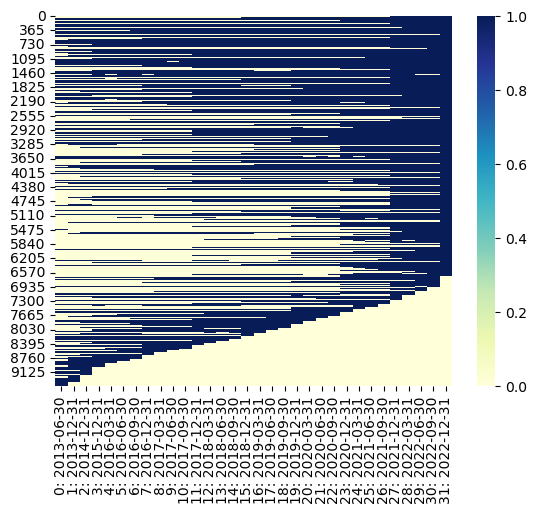

In [39]:
inv_portfolio_total_plot=inv_portfolio_total_nz!=0
import seaborn as sns
import matplotlib.pyplot as plt
threshold=1
inv_portfolio_total_nz[inv_portfolio_total_nz<threshold]=0
xticklabels = [f'{int(label)}: {(list(date_to_index.keys()))[int(label)]}' for label in np.arange(32)]

sns.heatmap(data=inv_portfolio_total_plot, cmap='YlGnBu',xticklabels=xticklabels)

<Axes: >

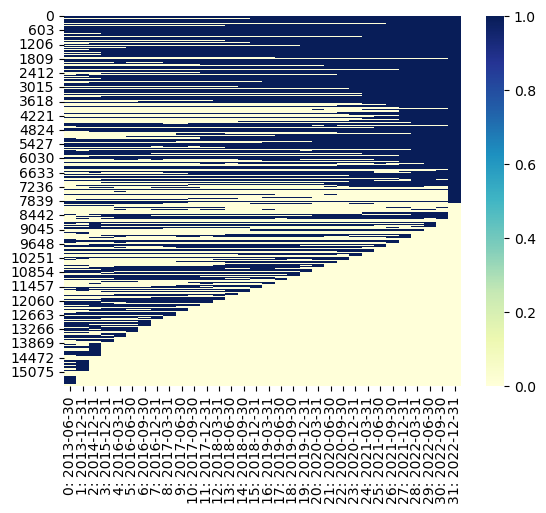

In [41]:
stock_ownership_plot=stock_ownership_nz!=0
xticklabels = [f'{int(label)}: {(list(date_to_index.keys()))[int(label)]}' for label in np.arange(32)]

sns.heatmap(data=stock_ownership_plot, cmap='YlGnBu',xticklabels=xticklabels)

In [72]:
def select_investor_all_quarter(data_3d, inv_index):
    """

    select investors from the index that have non zero entries for every quarter
    args:
        data_3d: dictionary containing the data
            dimensions:
                dim 0: tickers
                dim 1: investors
                dim 2: dates
        inv_index: index of the investor to select
            keys: investor name
            values: index of the investor
    return:
        inv_index_all_quarter: index of the investors that have non zero entries for every quarter
    """
    inv_index_all_quarter=[]
    for inv_name,inv_idx in inv_index.items():
        inv_data=data_3d[:,inv_idx,:]
        #print(f'inv_data.shape={np.sum(inv_data,0).shape}')
        if not (np.any((np.sum(inv_data,0))==0)):
            inv_index_all_quarter.append(inv_name)
    return inv_index_all_quarter

inv_index_all_quarter=select_investor_all_quarter(arr_vals, investor_to_index)




In [73]:
len(investor_to_index)
len(inv_index_all_quarter)

1859

In [69]:
#remove the funds with zero values from both the fund dimension and the vals_arr
np.sum(np.any(inv_portfolio_total==0,axis=1)==True)


7613

In [9]:
np.sum(np.any(stock_ownership==0,axis=1)==True)

12396

Do this initially to create the dense matrices for the multiaction.  This is a one-time thing.


In [14]:
#remove stocks with and investors with zero ownership in any quarter from arr_values, investors, and tickers
arr_vals_adjust=arr_vals[np.any(stock_ownership==0,axis=1)==False]
arr_vals_adjust=arr_vals_adjust[:,np.any(inv_portfolio_total==0,axis=1)==False]
investors_adjust=np.array(dict_vals["investors"])[np.any(inv_portfolio_total==0,axis=1)==False]
tickers_adjust=np.array(dict_vals["tickers"])[np.any(stock_ownership==0,axis=1)==False]
ticker_to_index_adjust={ticker: i for i, ticker in enumerate(tickers_adjust)}
investor_to_index_adjust={investor: i for i, investor in enumerate(investors_adjust)}
date_to_index=dict_vals["date_to_index"]


NameError: name 'stock_ownership' is not defined

In [14]:

data_3d={}
data_3d["values"]=arr_vals_adjust
data_3d["tickers"]=list(ticker_to_index_adjust.keys())
data_3d["investors"]=list(investor_to_index_adjust.keys())
data_3d["dates"]=list(date_to_index.keys())
data_3d["ticker_to_index"]=ticker_to_index_adjust
data_3d["investor_to_index"]=investor_to_index_adjust
data_3d["date_to_index"]=date_to_index

with open('data/3d_data_with_nz.pickle', 'wb') as handle:
    pickle.dump(data_3d, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
arr.shape
len(investor_to_index_adjust)

1859

In [6]:
arr=arr_vals_adjust
arr.shape
arr_binary=(arr>0).astype(np.int16)
arr_binary_adjusted=arr_binary.copy()
count=0
ratio_owned={}
ratio_owned_list=[]
for dt in date_to_index.values():
    for inv_key, inv_value in investor_to_index_adjust.items():
        row=arr_binary[:,inv_value,dt]
        sum_own=np.sum(row)
        sum_not_owned=np.sum(row==0)
        sum_total=sum_not_owned+sum_own
        
        # if more stocks are owned than not owned, convert some of the owned stocks to -1 to make the numbers equal
        # if more of stocks are not owned, convert enough stocks from 0 to -1 to make the total number of stocks with 
        # zeros and ones equal
        if (sum_own>sum_not_owned):
            indices_ones = np.where(row == 1)[0]
            
            # Randomly select indices to keep
            indices_to_keep = np.random.choice(indices_ones, size=sum_not_owned, replace=False)
            
            # Mark the rest as NaN
            indices_to_mark = np.setdiff1d(indices_ones, indices_to_keep)
            arr_binary_adjusted[indices_to_mark,inv_value,dt] = -1
            own_difference=sum_own-sum_not_owned
        else:
            indices_zeros = np.where(row == 0)[0]
            
            # Randomly select indices to keep
            indices_to_keep = np.random.choice(indices_zeros, size=sum_own, replace=False)
            
            # Mark the rest as NaN
            indices_to_mark = np.setdiff1d(indices_zeros, indices_to_keep)
            #arr_binary_adjusted[indices_to_mark] = -1
            arr_binary_adjusted[indices_to_mark,inv_value,dt] = -1
            
        #print (f'inv={inv_key}, dt={dt}, sum_own={sum_own}')
        #print (f'inv={inv_key}, dt={dt}, sum_not_owned={sum_not_owned},total={sum_own+sum_not_owned}')
        #if(count==0):
        #    ratio_owned[inv_key]=sum_own/(sum_own+sum_not_owned)
    count+=1
"""
for dt in date_to_index.values():
    for ticker_key, ticker_value in ticker_to_index_adjust.items():
        row=arr_binary_adjusted[ticker_value,:,dt]
        sum_own=np.sum(row==1)
        sum_not_owned=np.sum(row==0)
        sum_total=sum_not_owned+sum_own
        #if (ticker_value%100==0):
        #    print(f'ticker_valu={ticker_value} out of {len(ticker_to_index_adjust)}')
        
        # if more stocks are owned than not owned, convert some of the owned stocks to -1 to make the numbers equal
        # if more of stocks are not owned, convert enough stocks from 0 to -1 to make the total number of stocks with 
        # zeros and ones equal
        if (sum_own>sum_not_owned):
            indices_ones = np.where(row == 1)[0]
            
            # Randomly select indices to keep
            indices_to_keep = np.random.choice(indices_ones, size=sum_not_owned, replace=False)
            
            # Mark the rest as NaN
            indices_to_mark = np.setdiff1d(indices_ones, indices_to_keep)
            arr_binary_adjusted[ticker_value,indices_to_mark,dt] = -1
            own_difference=sum_own-sum_not_owned
        else:
            indices_zeros = np.where(row == 0)[0]
            
            # Randomly select indices to keep
            indices_to_keep = np.random.choice(indices_zeros, size=sum_own, replace=False)
            
            # Mark the rest as NaN
            indices_to_mark = np.setdiff1d(indices_zeros, indices_to_keep)
            arr_binary_adjusted[ticker_value,indices_to_mark,dt] = -1
            
        #print (f'inv={inv_key}, dt={dt}, sum_own={sum_own}')
        #print (f'inv={inv_key}, dt={dt}, sum_not_owned={sum_not_owned},total={sum_own+sum_not_owned}')
        #if(count==0):
        #    ratio_owned[inv_key]=sum_own/(sum_own+sum_not_owned)


"""
for dt in date_to_index.values():
    for inv_key, inv_value in investor_to_index_adjust.items():
        row=arr_binary_adjusted[:,inv_value,dt]
        sum_own=np.sum(row==1)
        sum_not_owned=np.sum(row==0)
        sum_total=sum_not_owned+sum_own
        print (f'inv={inv_key}, dt={dt}, sum_own={sum_own}')
        print (f'inv={inv_key}, dt={dt}, sum_not_owned={sum_not_owned},total={sum_own+sum_not_owned}')
        if(count==0):
            ratio_owned[inv_key]=sum_own/(sum_own+sum_not_owned)

print(f'ratio_owned={ratio_owned}')        


inv=VANGUARD GROUP INC, dt=0, sum_own=820
inv=VANGUARD GROUP INC, dt=0, sum_not_owned=820,total=1640
inv=BLACKROCK INC, dt=0, sum_own=651
inv=BLACKROCK INC, dt=0, sum_not_owned=651,total=1302
inv=BERKSHIRE HATHAWAY INC, dt=0, sum_own=37
inv=BERKSHIRE HATHAWAY INC, dt=0, sum_not_owned=37,total=74
inv=STATE STREET CORP, dt=0, sum_own=861
inv=STATE STREET CORP, dt=0, sum_not_owned=861,total=1722
inv=FMR LLC, dt=0, sum_own=988
inv=FMR LLC, dt=0, sum_not_owned=988,total=1976
inv=BANK OF MONTREAL, dt=0, sum_own=1524
inv=BANK OF MONTREAL, dt=0, sum_not_owned=1524,total=3048
inv=PRICE T ROWE ASSOCIATES INC, dt=0, sum_own=1472
inv=PRICE T ROWE ASSOCIATES INC, dt=0, sum_not_owned=1472,total=2944
inv=LILLY ENDOWMENT INC, dt=0, sum_own=1
inv=LILLY ENDOWMENT INC, dt=0, sum_not_owned=1,total=2
inv=GEODE CAPITAL MANAGEMENT LLC, dt=0, sum_own=782
inv=GEODE CAPITAL MANAGEMENT LLC, dt=0, sum_not_owned=782,total=1564
inv=MITSUBISHI UFJ FINANCIAL GROUP INC, dt=0, sum_own=1
inv=MITSUBISHI UFJ FINANCIAL GRO

In [9]:
df_out=pd.DataFrame(columns=['ticker','investorname','calendardate','value'])
row_list_dict=[]
#for investor in range(num_investors):
#    for d in range(num_dates):
#        for s in range(num_picks):
for dt_key,date_val in date_to_index.items():
    for inv_key,investor_val in investor_to_index_adjust.items():
        for ticker_key,ticker_val in ticker_to_index_adjust.items():
            own_value=arr_binary_adjusted[ticker_val,investor_val,date_val]
            if (own_value==-1):
                continue
            else:
                dict_entry={'ticker':ticker_key,'investorname':inv_key,'calendardate':dt_key,'value':own_value}
                row_list_dict.append(dict_entry)
    break
df_out=pd.DataFrame(row_list_dict)

In [10]:
df_out.count()
len(df_out['ticker'].unique())
df_out.to_csv('data/equal_sample_test_1q.csv',index=False)

In [68]:
def find_percent_ownership(arr):
    """
    Get a 3d matrix of $ ownership for each investor, ticker, date
    return a matrix of % ownership for each investor, ticker, date where the percentage represents 
    the percentage allocation of the portfolio to this stock
    Args:
        arr ([float]): a 3d array of $ ownership for each investor, ticker, date
                        dimensiojn 0: ticker
                        dimension 1: investor
                        dimension 2: date
    Returns:
        3d array with the same dimensions as arr, but with % ownership instead of $ ownership
    """

    # Get the total value of the portfolio for each investor and date
    # Shape: (num_investors, num_dates)
    total_value = np.sum(arr, axis=0)

    # Divide each element of arr by the total value for the corresponding investor and date
    # Shape: (num_tickers, num_investors, num_dates)
    percent_ownership = arr / (total_value+.00000001)

    return percent_ownership

# create a test matric

# Create a mock array
arr = np.array([[[1, 2], [3, 4], [5, 6]], [[2, 3], [4, 5], [6, 7]]])

# Call the function
percent_ownership = find_percent_ownership(arr)

# Print the resulting percent_ownership array
#print(percent_ownership)
arr[:,0,0]
percent_ownership[:,2,0]

def test_find_percent_ownership():
    # Create a mock array
    arr = np.array([[[1, 2], [3, 4], [5, 6]], [[2, 3], [4, 5], [6, 7]]])

    # Call the function
    percent_ownership = find_percent_ownership(arr)

    # Get the sum of the percentages for each investor and date
    total_percentages = np.sum(percent_ownership, axis=0)

    # Check that the sums are close to 1
    assert np.allclose(total_percentages, 1), "Percentages do not sum to 1"

test_find_percent_ownership()

In [78]:
#1 apply the percentage ownership to the portfolio value
#2 reverse the date dimension of both arrays, and also the date index

arr_percent_ownership=find_percent_ownership(arr_vals_adjust)

#reverse the matrices
arr_percent_ownership_rev=arr_percent_ownership[:,:,::-1]
arr_vals_adjust_rev=arr_vals_adjust[:,:,::-1]
#reverse the date dimension
date_to_index_rev=r = dict(reversed(list(date_to_index.items())))
date_to_index_rev
ticker_to_index_local=ticker_to_index_adjust
investor_to_index_local=investor_to_index_adjust

#find then percent change in the values of the portfolio for different dates
num_tickers=arr_percent_ownership_rev.shape[0]
num_investors=arr_percent_ownership_rev.shape[1]
num_dates=arr_percent_ownership_rev.shape[2]


arr_change=np.zeros((num_tickers,num_investors,num_dates-1))
arr_change_percent=np.zeros((num_tickers,num_investors,num_dates-1))
inv_portfolio_total=np.sum(arr_vals_adjust_rev,axis=0)
for dt in range(num_dates-1):
    arr_change[:,:,dt]=arr_vals_adjust_rev[:,:,dt+1]-arr_vals_adjust_rev[:,:,dt]
    arr_change_percent[:,:,dt]=arr_change[:,:,dt]/(inv_portfolio_total[:,dt]+.0000000001)

arr_change_percent



array([[[ 8.81953458e-03,  1.22613938e-02, -2.25604924e-03, ...,
         -1.23069520e-02,  3.72544882e-04, -3.15941452e-03],
        [ 1.15056086e-02,  8.68428502e-03, -2.35256420e-03, ...,
         -1.19110408e-02,  1.29748564e-04, -2.82229960e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.57458225e-02,  4.64949237e-03, -2.60504816e-02],
        ...,
        [-2.13256970e-01,  1.12481280e-02, -7.67975634e-03, ...,
          0.00000000e+00,  0.00000000e+00,  5.69268881e-02],
        [ 3.09187279e-01,  2.95884316e-01, -9.78792822e-03, ...,
         -2.87321374e-01, -2.84252416e-03, -4.33810152e-02],
        [ 2.87740379e-03,  3.44416120e-03, -2.48952626e-02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.95782118e-03,  6.09333371e-03,  5.95570517e-03, ...,
         -7.92126491e-03, -4.19614727e-03,  2.07495361e-03],
        [ 3.48554836e-03,  6.19134817e-03, -1.37792682e-04, ...,
         -8.37317265e-03, -4.87752082e

In [70]:
#this should be useless now that I have the function
#need to delete once I have the function working
arr_vals_adjust.shape
num_dates=arr_vals_adjust.shape[2]
num_investors=arr_vals_adjust.shape[1]
num_picks=arr_vals_adjust.shape[0]

for dt_ind in range(num_dates):
    quarterly_slice=arr_vals_adjust[:,:,dt_ind]
    #dim0 is stocks dim1 is investors
    inv_holdings=np.sum(quarterly_slice,axis=0)

    quarterly_slice_percent=quarterly_slice/inv_holdings
    #for inv_key,inv_value in investor_to_index_adjust.items():
    #    print(f'inv={inv_key},inv_value={inv_value},inv_holdings={inv_holdings[inv_value]/1e6:,}')
    # 
    large_holdings=np.where(quarterly_slice_percent>.01)
    len(large_holdings[0])

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_88635/4052910242.py:13: RuntimeWarning: invalid value encountered in divide
  quarterly_slice_percent=quarterly_slice/inv_holdings


hol

In [51]:
holding_changes=np.diff(arr_vals_adjust,axis=2)
holding_changes.shape
holding_changes_percent=holding_changes[:,:,0]/(inv_holdings+.01)
#large_holding_changes=np.where(holding_changes_percent[:,:,0]>.01)
large_holdings_changes=np.where(holding_changes_percent>.001)
len(large_holdings_changes[0])
date_to_index.items()

dict_items([('2022-12-31', 0), ('2022-09-30', 1), ('2022-06-30', 2), ('2022-03-31', 3), ('2021-12-31', 4), ('2021-09-30', 5), ('2021-06-30', 6), ('2021-03-31', 7), ('2020-12-31', 8), ('2020-09-30', 9), ('2020-06-30', 10), ('2020-03-31', 11), ('2019-12-31', 12), ('2019-09-30', 13), ('2019-06-30', 14), ('2019-03-31', 15), ('2018-12-31', 16), ('2018-09-30', 17), ('2018-06-30', 18), ('2018-03-31', 19), ('2017-12-31', 20), ('2017-09-30', 21), ('2017-06-30', 22), ('2017-03-31', 23), ('2016-12-31', 24), ('2016-09-30', 25), ('2016-06-30', 26), ('2016-03-31', 27), ('2015-12-31', 28), ('2014-12-31', 29), ('2013-12-31', 30), ('2013-06-30', 31)])

The code in the cells below is the real code

In [7]:
def select_dimension_subset(df, dimension_name='investorname'):
    """
    Selects a subset of the specified dimension from the input DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame to select the dimension subset from.
    dimension_name (str): The name of the dimension to select the subset for. Defaults to 'investorname'.

    Returns:
    dimension_subset (Index): The resulting subset of the specified dimension.
    """
    # Group the DataFrame by the specified dimension and calendardate, and sum the values
    grouped_df = df.groupby([dimension_name, 'calendardate']).sum()

    # Pivot the grouped DataFrame using the specified dimension as the index and calendardate as the columns
    dimension_quarter_table = grouped_df.pivot_table(index=dimension_name, columns='calendardate', values='value')

    # Select the rows in the DataFrame where all quarters have a value greater than zero for the specified dimension
    all_quarters_positive = (dimension_quarter_table > 0).all(axis=1)
    dimension_subset = dimension_quarter_table.loc[all_quarters_positive].index

    # Return the resulting subset of the specified dimension
    return dimension_subset

investor_subset=select_dimension_subset(df,'investorname')
len(investor_subset)
ticker_subset=select_dimension_subset(df,'ticker')
len(ticker_subset)

3266

In [8]:
filtered_df = df[df['ticker'].isin(ticker_subset) & df['investorname'].isin(investor_subset)]
subset_investor_to_index={inv_name:inv_ind for inv_ind,inv_name in enumerate(investor_subset)}
subset_ticker_to_index={ticker_name:ticker_ind for ticker_ind,ticker_name in enumerate(ticker_subset)}
subset_date_to_index={date:date_ind for date_ind,date in enumerate(sorted(df['calendardate'].unique().tolist()))}

In [9]:
importlib.reload(dp)
arr_vals=dp.get_dense_values(filtered_df,subset_ticker_to_index,subset_investor_to_index,subset_date_to_index,'value')
arr_vals.shape
arr_units=dp.get_dense_values(filtered_df,subset_ticker_to_index,subset_investor_to_index,subset_date_to_index,'units')
arr_units.shape
arr_price=dp.get_dense_values(filtered_df,subset_ticker_to_index,subset_investor_to_index,subset_date_to_index,'price')
arr_price.shape

(3266, 1859, 32)

In [11]:
subset_data_dict={
    'arr_vals':arr_vals,
    'arr_units':arr_units,
    'arr_price':arr_price,
    'subset_ticker_to_index':subset_ticker_to_index,
    'subset_investor_to_index':subset_investor_to_index,
    'subset_date_to_index':subset_date_to_index,
    'subset_file_name':'data/subset_data_dict.pkl'
}
with open(subset_data_dict['subset_file_name'],'wb') as f:
    pickle.dump(subset_data_dict,f)


In [7]:
#read the subset data dict
with open('data/subset_data_dict.pkl','rb') as f:
    subset_data_dict=pickle.load(f)

In [8]:
#calculate the total value of the portfolio for each investor for each quarter
arr_vals=subset_data_dict['arr_vals']
arr_units=subset_data_dict['arr_units']
arr_price=subset_data_dict['arr_price']
subset_ticker_to_index=subset_data_dict['subset_ticker_to_index']
subset_investor_to_index=subset_data_dict['subset_investor_to_index']
subset_date_to_index=subset_data_dict['subset_date_to_index']


In [9]:
inv_total_holdings=arr_vals.sum(axis=0)
change_in_inv_holdings=np.diff(arr_units,axis=2)
change_in_inv_holdings_value=change_in_inv_holdings*arr_price[:,:,1:]
change_in_inv_holdings_value.shape
pct_change_in_inv_holdings_value=change_in_inv_holdings_value/(inv_total_holdings[:,:-1]+.0000000001)
pct_change_in_inv_holdings_value.shape
(inv_total_holdings[:,:-1]).shape

(1859, 31)

In [77]:
import ipywidgets as widgets

# Define the list of tickers, investors, and dates
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
investors = ['BERKSHIRE HATHAWAY INC', 'VANGUARD GROUP INC', 'STATE STREET CORP', 'FMR LLC']
dates = ['2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31']

# Create the ticker selection widget
ticker_selection = widgets.SelectMultiple(
    options=tickers,
    value=[tickers[0]],
    description='Tickers:',
    disabled=False
)

# Create the investor selection widget
investor_selection = widgets.SelectMultiple(
    options=investors,
    value=[investors[0]],
    description='Investors:',
    disabled=False
)

# Create the date selection widget
date_selection = widgets.SelectMultiple(
    options=dates,
    value=[dates[0]],
    description='Dates:',
    disabled=False
)

# Display the widgets
display(ticker_selection)
display(investor_selection)
display(date_selection)

SelectMultiple(description='Tickers:', index=(0,), options=('AAPL', 'AMZN', 'GOOGL', 'MSFT'), value=('AAPL',))

SelectMultiple(description='Investors:', index=(0,), options=('BERKSHIRE HATHAWAY INC', 'VANGUARD GROUP INC', …

SelectMultiple(description='Dates:', index=(0,), options=('2016-06-30', '2016-09-30', '2016-12-31', '2017-03-3…

In [87]:
#checck values:
#pick ticker subset
#pick investor subset
#pick date subset
ticker_subset=['AAPL','AMZN','GOOGL','MSFT']
investor_subset=['BERKSHIRE HATHAWAY INC','VANGUARD GROUP INC','STATE STREET CORP','FMR LLC']
date_subset=['2016-06-30','2016-09-30','2016-12-31','2017-03-31']
ticker_subset_index_local={ticker: subset_ticker_to_index[ticker] for ticker in ticker_subset}
#subset_ticker_to_index['GOOGL']
investor_subset_index_local={investor: subset_investor_to_index[investor] for investor in investor_subset}
date_subset_index_local={date: subset_date_to_index[date] for date in date_subset}
#list(subset_date_to_index.keys())
#arr_vals[[2,4,5],[1,2],0:2]
meshgrid = np.ix_(list(ticker_subset_index_local.values()), list(investor_subset_index_local.values()), list(date_subset_index_local.values()))

#arr_vals[ ,list(investor_subset_index_local.values()),list(date_subset_index_local.values())]
#list(investor_subset_index_local.values())
arr=arr_vals[meshgrid]
change_in_inv_holdings_value.shape
ch=change_in_inv_holdings_value[meshgrid]
small_units=arr_units[meshgrid]
small_price=arr_price[meshgrid]
arr[0,0,:]
small_units[0,0,:]
arr[0,0,:]-small_units[0,0,:]*small_price[0,0,:]




array([ 9136384.,   761600., 47033856., 85374976.], dtype=float32)

In [75]:
ch[0,0,:]

array([0.0000000e+00, 4.8451743e+09, 1.0295636e+10, 1.2021926e+08],
      dtype=float32)

In [22]:
pct_change_in_inv_holdings_value

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.69032370e-03, -2.12993677e-04, -2.68182950e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.08393806e-05,  1.91430765e-04,  4.40360140e-03, ...,
         -7.42069169e-05, -5.12652041e-04,  3.19207524e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

Next steps, save subset dimensions and data cubes. 
- save it to one file and see how big it is
- check if units * price = value
- create percent allocations
- create stock buy sells (change of units * price?)
- create percent change of value (as percent of previous capital)
- create a small sythetic dataset to test the multiaction


what do I need to do now
- make the code for picking dimensions generic (take column names as input)
- make the code for picking measures generic (take column names as input)
- make the code for picking the non zero investors generic (take column names as input)
- create code to save dimensions and measures and the filenames
- create the code to read the dimensions and measures and given the filenames


In [118]:
# Create a pivot table with ticker as the index, investorname as the columns, and calendardate as the third dimension
table_3d = df.pivot_table(index='ticker', columns='investorname', values='value', aggfunc='sum', fill_value=0, dropna=False)

# Add the calendardate as the third dimension to the pivot table
#table_3d = table_3d.stack().unstack(1).unstack()

In [121]:
# Create a pivot table with ticker and investorname as the index, and calendardate as the columns
table_2d = df.pivot_table(index=['ticker', 'investorname'], columns='calendardate', values='value', aggfunc='sum', fill_value=0, dropna=False)


: 

: 

In [27]:
df

ticker                      investorname calendardate         value   
0           EAR         PATIENT SQUARE CAPITAL LP   2022-12-31  1.819449e+11  \
1          AAPL                VANGUARD GROUP INC   2022-12-31  1.660831e+11   
2          MSFT                VANGUARD GROUP INC   2022-12-31  1.541239e+11   
3          AAPL                     BLACKROCK INC   2022-12-31  1.337250e+11   
4          MSFT                     BLACKROCK INC   2022-12-31  1.275945e+11   
...         ...                               ...          ...           ...   
43913121   LSI1   PENSECO FINANCIAL SERVICES CORP   2013-06-30  0.000000e+00   
43913122    AOL   PENSECO FINANCIAL SERVICES CORP   2013-06-30  0.000000e+00   
43913123    ALU   PENSECO FINANCIAL SERVICES CORP   2013-06-30  0.000000e+00   
43913130  ENRNQ  NATIONAL PENN INVESTORS TRUST CO   2013-06-30  0.000000e+00   
43913131  ABIZQ  NATIONAL PENN INVESTORS TRUST CO   2013-06-30  0.000000e+00   

                 units  price  
0         3.164260e+08  575.0  
1         1.278251e+09  129.0  
2         6.426649e+08  239.0  
3         1.029208e+09  129.0  
4         5.320427e+08  239.0  
...                ...    ...  
43913121  1.500000e+01    0.0  
43913122  3.000000e+00    0.0  
43913123  5.400000e+01    0.0  
43913130  3.050000e+04    0.0  
43913131  1.300000e+04    0.0  

[33563204 rows x 6 columns]

In [9]:
# Create a pivot table
pivot = pd.pivot_table(df, values='value', index=['ticker', 'investorname'], columns='calendardate')

# Fill NaN values with zeros
pivot.fillna(0, inplace=True)

# Convert the pivot table to a 3D NumPy array
array_3d = np.array([pivot.loc[ticker].values for ticker in pivot.index.levels[0]]).astype('float32')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15662,) + inhomogeneous part.

In [10]:
pivot

calendardate                                         2013-06-30   2013-12-31   
ticker     investorname                                                        
0001388994 HUNTINGTON NATIONAL BANK                         0.0          0.0  \
A          1 NORTH WEALTH SERVICES LLC                      0.0          0.0   
           1832 ASSET MANAGEMENT LP                  54661000.0  106235000.0   
           1919 INVESTMENT COUNSEL LLC                  26000.0          0.0   
           2XIDEAS AG                                       0.0          0.0   
...                                                         ...          ...   
ZYXI       ZACKS INVESTMENT MANAGEMENT                      0.0          0.0   
           ZEBRA CAPITAL MANAGEMENT LLC                     0.0          0.0   
           ZURCHER KANTONALBANK ZURICH CANTONALBANK         0.0          0.0   
ZZZOF      IFP ADVISORS INC                                 0.0          0.0   
           INVERNESS COUNSEL LLC                            0.0          0.0   

calendardate                                         2014-12-31  2015-12-31   
ticker     investorname                                                       
0001388994 HUNTINGTON NATIONAL BANK                         0.0         0.0  \
A          1 NORTH WEALTH SERVICES LLC                      0.0         0.0   
           1832 ASSET MANAGEMENT LP                  70891000.0    208000.0   
           1919 INVESTMENT COUNSEL LLC                      0.0         0.0   
           2XIDEAS AG                                       0.0         0.0   
...                                                         ...         ...   
ZYXI       ZACKS INVESTMENT MANAGEMENT                      0.0         0.0   
           ZEBRA CAPITAL MANAGEMENT LLC                     0.0         0.0   
           ZURCHER KANTONALBANK ZURICH CANTONALBANK         0.0         0.0   
ZZZOF      IFP ADVISORS INC                                 0.0         0.0   
           INVERNESS COUNSEL LLC                            0.0         0.0   

calendardate                                         2016-03-31  2016-06-30   
ticker     investorname                                                       
0001388994 HUNTINGTON NATIONAL BANK                         0.0         0.0  \
A          1 NORTH WEALTH SERVICES LLC                      0.0         0.0   
           1832 ASSET MANAGEMENT LP                     54000.0     42000.0   
           1919 INVESTMENT COUNSEL LLC                      0.0         0.0   
           2XIDEAS AG                                       0.0         0.0   
...                                                         ...         ...   
ZYXI       ZACKS INVESTMENT MANAGEMENT                      0.0         0.0   
           ZEBRA CAPITAL MANAGEMENT LLC                     0.0         0.0   
           ZURCHER KANTONALBANK ZURICH CANTONALBANK         0.0         0.0   
ZZZOF      IFP ADVISORS INC                                 0.0         0.0   
           INVERNESS COUNSEL LLC                            0.0         0.0   

calendardate                                         2016-09-30  2016-12-31   
ticker     investorname                                                       
0001388994 HUNTINGTON NATIONAL BANK                         0.0         0.0  \
A          1 NORTH WEALTH SERVICES LLC                      0.0         0.0   
           1832 ASSET MANAGEMENT LP                     42000.0     82000.0   
           1919 INVESTMENT COUNSEL LLC                      0.0         0.0   
           2XIDEAS AG                                       0.0         0.0   
...                                                         ...         ...   
ZYXI       ZACKS INVESTMENT MANAGEMENT                      0.0         0.0   
           ZEBRA CAPITAL MANAGEMENT LLC                     0.0         0.0   
           ZURCHER KANTONALBANK ZURICH CANTONALBANK         0.0         0.0   
ZZZOF      IFP ADVISORS INC       

In [25]:

import numpy as np

# Group by 'ticker', 'investorname', and 'calendardate' and take the 'value'
grouped = df.groupby(['ticker', 'investorname', 'calendardate'])['value'].first()

# Unstack the multi-index series into a 3D structure
unstacked = grouped.unstack(level=['ticker', 'investorname'])

# Fill missing values with zero
unstacked.fillna(0, inplace=True)

# Convert the DataFrame to a numpy array
array_3d = unstacked.to_numpy().astype(np.float32)

In [26]:
array_3d.shape

(32, 4048757)